# Selection on Observables

## Purpose

The purpose of this notebook is to illustrate an example of the workflow outlined in [Brathwaite and Walker (2017)](https://arxiv.org/abs/1706.07502). This simple application aims at highlighting the importance of causal structure in estimating causal effects of interest reflecting changes resulting from policy proposals. The basic idea is to show that when we control for intermediate variables of some variable of interest in a causal graph, we never recover the true causal parameter on the variable of interest.

This notebook uses the dataset and the MNL utility specification from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900) for demonstration.
The rest of the notebook is organized as follows:
 - Defining different causal graphs representing different views for how individuals make mode choices. These causal graphs are based on the MNL utility functions from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900)
 - Simulating data based on the different beliefs about the data generating process illustrated by both causal graphs.
 - Perturbing one of the variables (e.g.: Travel Distance) to simulate a policy intervention.
 - Calculating and plotting the distributions of treatment effects according to different causal graphs.

# Import Needed Libraries

In [2]:
# Built-in libraries
import sys

# Third party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import copy
from causalgraphicalmodels import CausalGraphicalModel
from collections import defaultdict, OrderedDict
import pylogit as pl

# Local libraries
import causal2020.observables.distfit as distfit
import causal2020.observables.simulation as sim
import causal2020.observables.regression as reg
import causal2020.observables.availability as av
from checkrs.utils import simulate_choice_vector
from causal2020.observables.graphs import (
    IND_UTILITY,
    DA_UTILITY,
    SHARED_2_UTILITY,
    SHARED_3P_UTILITY,
    WTW_UTILITY,
    DTW_UTILITY,
    WTD_UTILITY,
    WALK_UTILITY,
    BIKE_UTILITY,
)


Bad key "text.kerning_factor" on line 4 in
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Set Notebook Parameters

In [3]:
# Path to Data
DATA_PATH = "../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv"

# Path to computational code used
# in simulation loop
SIMULATE_NODES_WIDE = open("../../src/causal2020/observables/simworkflow.py").read()
SIMULATE_PERTURB = open("../../src/causal2020/observables/simperturb.py").read()

In [4]:
# Alternative id column from long format data
ALT_ID_COL = "mode_id"

# Individual specific variables list
IND_SPEC_VARS = [
    "household_size",
    "num_kids",
    "num_cars",
    "num_licensed_drivers",
]

# Alternative specific variables dictionary
# Key is alternative number, value is a list
# of alternative specific nodes without parents
ALT_SPEC_DICT = {
    1: ["total_travel_distance"],
    2: ["total_travel_distance"],
    3: ["total_travel_distance"],
    4: ["total_travel_time"],
    5: ["total_travel_time"],
    6: ["total_travel_time"],
    7: ["total_travel_distance"],
    8: ["total_travel_distance"],
}

# Trip specific variables list
TRIP_SPEC_VARS = ["cross_bay"]

# Alternative name dictionary
# Key is alternative number
# value is alternative number snake cased
ALT_NAME_DICT = {
    1: "drive_alone",
    2: "shared_2",
    3: "shared_3p",
    4: "wtw",
    5: "dtw",
    6: "wtd",
    7: "walk",
    8: "bike",
}

ALT_ID_TO_MODE_NAME = {
    1: "Drive Alone",
    2: "Shared Ride 2",
    3: "Shared Ride 3+",
    4: "Walk-Transit-Walk",
    5: "Drive-Transit-Walk",
    6: "Walk-Transit-Drive",
    7: "Walk",
    8: "Bike",
}

# Variable type Dictionary
# Key is string with variable name from previous
# dictionaries and lists, value is a string
# with type of the variable
VARS_TYPE = {
    "num_kids": "categorical",
    "household_size": "categorical",
    "num_cars": "categorical",
    "num_licensed_drivers": "categorical",
    "cross_bay": "categorical",
    "total_travel_time": "continuous",
    "total_travel_distance": "continuous",
    "total_travel_cost": "continuous",
}

# Distribution to be explored for continuous variables
CONT_DISTS = ["norm", "alpha", "beta", "gamma", "expon", "gumbel"]

In [5]:
# Declare regression parameters

REGS_DA = {
    1: ("total_travel_distance", "total_travel_cost"),
    2: ("total_travel_distance", "total_travel_time"),
}

REGS_TYPE_DA = {1: "linear", 2: "linear"}


REGS_SHARED_2 = {
    1: ("total_travel_distance", "total_travel_cost"),
    2: ("total_travel_distance", "total_travel_time"),
}

REGS_TYPE_SHARED_2 = {1: "linear", 2: "linear"}


REGS_SHARED_3P = {
    1: ("total_travel_distance", "total_travel_cost"),
    2: ("total_travel_distance", "total_travel_time"),
}

REGS_TYPE_SHARED_3P = {1: "linear", 2: "linear"}


REGS_WTW = {1: ("total_travel_time", "total_travel_cost")}

REGS_TYPE_WTW = {1: "linear"}


REGS_DTW = {1: ("total_travel_time", "total_travel_cost")}

REGS_TYPE_DTW = {1: "linear"}


REGS_WTD = {1: ("total_travel_time", "total_travel_cost")}

REGS_TYPE_WTD = {1: "linear"}

In [6]:
# Parameters for conversion from Wide to Long

IND_VARIABLES = [
    "num_kids",
    "household_size",
    "num_cars",
    "num_licensed_drivers",
    "cross_bay",
]


# Dictionary of Alternative Specific Variables
# TODO: verify whether all variables are needed
# for each alternative
ALT_VARYING_VARIABLES = {
    u"total_travel_time": dict(
        [
            (1, "total_travel_time_drive_alone"),
            (2, "total_travel_time_shared_2"),
            (3, "total_travel_time_shared_3p"),
            (4, "total_travel_time_wtw"),
            (5, "total_travel_time_dtw"),
            (6, "total_travel_time_wtd"),
        ]
    ),
    u"total_travel_cost": dict(
        [
            (1, "total_travel_cost_drive_alone"),
            (2, "total_travel_cost_shared_2"),
            (3, "total_travel_cost_shared_3p"),
            (4, "total_travel_cost_wtw"),
            (5, "total_travel_cost_dtw"),
            (6, "total_travel_cost_wtd"),
        ]
    ),
    u"total_travel_distance": dict(
        [
            (1, "total_travel_distance_drive_alone"),
            (2, "total_travel_distance_shared_2"),
            (3, "total_travel_distance_shared_3p"),
            (7, "total_travel_distance_walk"),
            (8, "total_travel_distance_bike"),
        ]
    ),
}


# Dictionary of alternative availability variables
AVAILABILITY_VARIABLES = {
    1: "drive_alone_AV",
    2: "shared_2_AV",
    3: "shared_3p_AV",
    4: "wtw_AV",
    5: "dtw_AV",
    6: "wtd_AV",
    7: "walk_AV",
    8: "bike_AV",
}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
CUSTOM_ALT_ID = "mode_id"

OBS_ID_COL = "observation_id"

# Declare choice column
CHOICE_COL = "sim_choice"

In [7]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

MNL_SPECIFICATION = OrderedDict()
MNL_NAMES = OrderedDict()

MNL_SPECIFICATION["intercept"] = [2, 3, 4, 5, 6, 7, 8]
MNL_NAMES["intercept"] = [
    "ASC Shared Ride: 2",
    "ASC Shared Ride: 3+",
    "ASC Walk-Transit-Walk",
    "ASC Drive-Transit-Walk",
    "ASC Walk-Transit-Drive",
    "ASC Walk",
    "ASC Bike",
]

MNL_SPECIFICATION["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
MNL_NAMES["total_travel_time"] = [
    "Travel Time, units:min (All Auto Modes)",
    "Travel Time, units:min (All Transit Modes)",
]

MNL_SPECIFICATION["total_travel_cost"] = [[4, 5, 6]]
MNL_NAMES["total_travel_cost"] = ["Travel Cost, units:$ (All Transit Modes)"]

MNL_SPECIFICATION["cost_per_distance"] = [1, 2, 3]
MNL_NAMES["cost_per_distance"] = [
    "Travel Cost per Distance, units:$/mi (Drive Alone)",
    "Travel Cost per Distance, units:$/mi (SharedRide-2)",
    "Travel Cost per Distance, units:$/mi (SharedRide-3+)",
]

MNL_SPECIFICATION["cars_per_licensed_drivers"] = [[1, 2, 3]]
MNL_NAMES["cars_per_licensed_drivers"] = [
    "Autos per licensed drivers (All Auto Modes)"
]

MNL_SPECIFICATION["total_travel_distance"] = [7, 8]
MNL_NAMES["total_travel_distance"] = [
    "Travel Distance, units:mi (Walk)",
    "Travel Distance, units:mi (Bike)",
]

MNL_SPECIFICATION["cross_bay"] = [[2, 3]]
MNL_NAMES["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

MNL_SPECIFICATION["household_size"] = [[2, 3]]
MNL_NAMES["household_size"] = ["Household Size (Shared Ride 2 & 3+)"]

MNL_SPECIFICATION["num_kids"] = [[2, 3]]
MNL_NAMES["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

# Load and Describe Data

In [8]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(DATA_PATH)

# Look at the mode shares in the data set

mode_counts = (
    bike_data_long.loc[bike_data_long.choice == 1, "mode_id"]
    .value_counts()
    .loc[range(1, 9)]
)

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [ALT_ID_TO_MODE_NAME[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

# Choice Model Estimation

For purposes of this task, we use the MNL specification from Brathwaite and Walker (2016) and estimate the model resulting from such a specification. We assume that the estimated model parameters represent the "true" model parameters.

In [9]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(
    data=bike_data_long,
    alt_id_col=ALT_ID_COL,
    obs_id_col=OBS_ID_COL,
    choice_col="choice",
    specification=MNL_SPECIFICATION,
    model_type="MNL",
    names=MNL_NAMES,
)

num_vars = len(reduce(lambda x, y: x + y, MNL_NAMES.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars), method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimation Time for Point Estimation: 0.35 seconds.
Final log-likelihood: -5,073.4276


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Fri, 18 Dec 2020   Pseudo R-squ.:                   0.332
Time:                             16:35:17   Pseudo R-bar-squ.:               0.330
AIC:                            10,184.855   Log-Likelihood:             -5,073.428
BIC:                            10,304.461   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0097      0.486     -2.079      0.038      -1.962      -0.058
ASC Shared Ride: 3+                                      3.4619      1.064      3.254      0.001       1.377       5.547
ASC Walk-Transit-Walk                                   -0.3921      0.288     -1.360      0.174      -0.957       0.173
ASC Drive-Transit-Walk                                  -2.6220      0.303     -8.660      0.000      -3.215      -2.029
ASC Walk-Transit-Drive                                  -2.9773      0.306     -9.725      0.000      -3.577      -2.377
ASC Walk                                                 1.5541      0.305      5.101      0.000       0.957       2.151
ASC Bike                                                -1.1059      0.305     -3.628      0.000      -1.703      -0.508
Travel Time, units:min (All Auto Modes)                 -0.0760      0.006    -13.728      0.000      -0.087      -0.065
Travel Time, units:min (All Transit Modes)              -0.0274      0.002    -12.768      0.000      -0.032      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1273      0.037     -3.472      0.001      -0.199      -0.055
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.0613      1.377     -3.675      0.000      -7.760      -2.362
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.3194      4.548     -4.467      0.000     -29.234     -11.405
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.9224     14.748     -6.165      0.000    -119.829     -62.016
Autos per licensed drivers (All Auto Modes)              1.2134      0.129      9.408      0.000       0.961       1.466
Travel Distance, units:mi (Walk)                        -1.0272      0.050    -20.437      0.000      -1.126      -0.929
Travel Distance, units:mi (Bike)                        -0.2873      0.024    -11.896      0.000      -0.335      -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.9280      0.327      2.839      0.005       0.287       1.569
Household Size (Shared Ride 2 & 3+)                      0.1136      0.045      2.523      0.012       0.025       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6868      0.054     12.820      0.000       0.582       0.792
========================================================================================================================
"""

# Show Causal Graphs

We generate two causal graphs based on the data at hand and the specified utility functions from above:

 * An "independent" causal graph: All nodes are independent and do not affect each other. Any change in any variable in the graph would not result in changes in other variables and would only affect the value of the utility function.
 * A "realistic" causal graph: The structure of this causal graph shows that some variables affect others. In this example, a change in travel distance affects travel time, travel cosst, and directly affects the utility function.

The outcome of each of the causal graphs is the utility of each variable. As such, we generate causal graphs based on the utility specification for each alternative.

## Independent Causal Graph

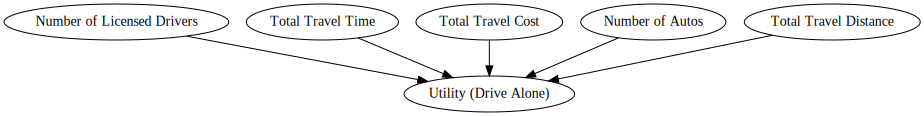

In [10]:
IND_UTILITY.draw()

## Realistic Causal Graphs

## Drive Alone

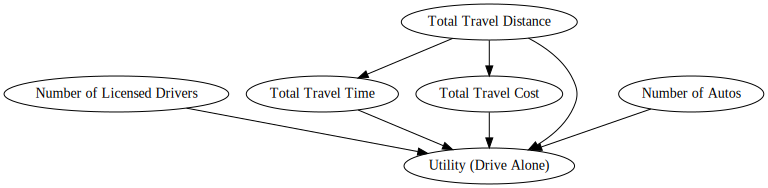

In [11]:
DA_UTILITY.draw()

## Shared-2

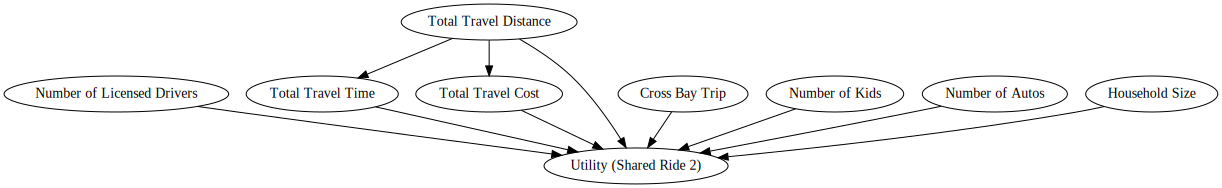

In [12]:
SHARED_2_UTILITY.draw()

## Shared-3+

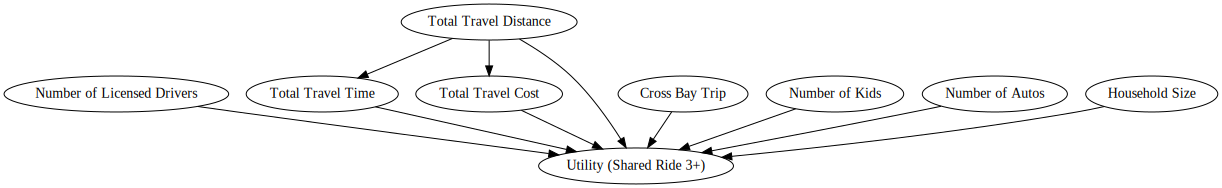

In [13]:
SHARED_3P_UTILITY.draw()

## Walk-Transit-Walk

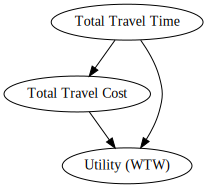

In [14]:
WTW_UTILITY.draw()

## Drive-Transit-Walk

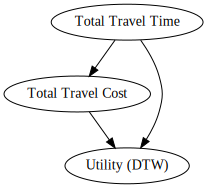

In [15]:
DTW_UTILITY.draw()

##  Walk-Transit-Drive

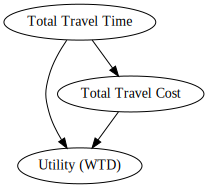

In [16]:
WTD_UTILITY.draw()

## Walk

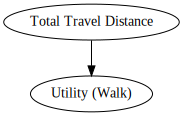

In [17]:
WALK_UTILITY.draw()

## Bike

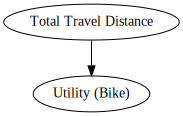

In [18]:
BIKE_UTILITY.draw()

# Selection on Observables Simulation

We simulate data based on the assumed structure of the causal diagrams and the original data from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900). This process goes as follows:

For the independent causal graph:
 * We fit a probability distribution for all the nodes in the utility function

For the realistic causal graph:
 * We fit a probability distribution for all the nodes without any parents/upstream notes in the causal graphs
 * We fit any regressions between the related explanatory variables

Based on these fitted distributions and regressions, we can then simulate data for the remaining nodes in each of the alternatives in our specified model.

## Distribution Fitting

In [19]:
bike_data_params = distfit.get_dist_node_no_parent(
    bike_data_long,
    ALT_ID_COL,
    OBS_ID_COL,
    ALT_SPEC_DICT,
    ALT_NAME_DICT,
    IND_SPEC_VARS,
    TRIP_SPEC_VARS,
    VARS_TYPE,
    CONT_DISTS,
)

Getting Distributions of Individual Specific Variables...
---------------------------------------------------------
Done...
Getting Distributions of Alternative Specific Variables...
----------------------------------------------------------
Fitted norm distribution with error=0.014164054487182288)
Fitted alpha distribution with error=0.014522128648725777)


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


Fitted beta distribution with error=0.0011963782652540424)
Fitted gamma distribution with error=0.0011394543473683448)
Fitted expon distribution with error=0.002052652669300775)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.014136723006166226)
Fitted alpha distribution with error=0.014457810916552023)
Fitted beta distribution with error=0.0012976882508515305)
Fitted gamma distribution with error=0.0012552378475140624)
Fitted expon distribution with error=0.0019967778289294194)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.014117434128009247)
Fitted alpha distribution with error=0.014462601227138085)
Fitted beta distribution with error=0.001276124018206852)
Fitted gamma distribution with error=0.0012547975031013958)
Fitted expon distribution with error=0.0020004181046601524)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.0004036911862300816

## Regression Fitting

Based on the structure of the "realistic" causal graphs assumed for each of the alternatives, we fit regressions that will allow us to simulate the remaining nodes in the causal graphs. The utility node will be simulated based on the utility function for each alternative.

## Drive Alone

In [20]:
drive_alone_df = bike_data_long.loc[bike_data_long["mode_id"] == 1]

drive_alone_df.reset_index(drop=True, inplace=True)

fitted_reg_da = reg.fit_alternative_regression(
    regressions=REGS_DA, reg_types=REGS_TYPE_DA, data=drive_alone_df
)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


## Shared-2

In [21]:
shared_2_df = bike_data_long.loc[bike_data_long["mode_id"] == 2]

shared_2_df.reset_index(drop=True, inplace=True)

fitted_reg_shared_2 = reg.fit_alternative_regression(
    regressions=REGS_SHARED_2, reg_types=REGS_TYPE_SHARED_2, data=shared_2_df
)

## Shared-3+

In [22]:
shared_3p_df = bike_data_long.loc[bike_data_long["mode_id"] == 3]

shared_3p_df.reset_index(drop=True, inplace=True)

fitted_reg_shared_3p = reg.fit_alternative_regression(
    regressions=REGS_SHARED_3P,
    reg_types=REGS_TYPE_SHARED_3P,
    data=shared_3p_df,
)

## Walk-Transit-Walk

In [23]:
wtw_df = bike_data_long.loc[bike_data_long["mode_id"] == 4]

wtw_df.reset_index(drop=True, inplace=True)

fitted_reg_wtw = reg.fit_alternative_regression(
    regressions=REGS_WTW, reg_types=REGS_TYPE_WTW, data=wtw_df
)

## Drive-Transit-Walk

In [24]:
dtw_df = bike_data_long.loc[bike_data_long["mode_id"] == 5]

dtw_df.reset_index(drop=True, inplace=True)

fitted_reg_dtw = reg.fit_alternative_regression(
    regressions=REGS_DTW, reg_types=REGS_TYPE_DTW, data=dtw_df
)

## Walk-Transit-Drive

In [25]:
wtd_df = bike_data_long.loc[bike_data_long["mode_id"] == 6]

wtd_df.reset_index(drop=True, inplace=True)

fitted_reg_wtd = reg.fit_alternative_regression(
    regressions=REGS_WTD, reg_types=REGS_TYPE_WTD, data=wtd_df
)

## Simulation

Identifying the probability distributions of parent nodes and identifying the relationships between connected nodes allows us to complete the selection-on-observables simulation. The workflow proceeds as follows:
* Simulate two sets of data for the X variables:
  - One where all the Xs are independent (i.e. the only edges in the causal graph are between the X and the outcome variable (which is the value of the utility function)).
  - One based on a realistic causal graph with confounders. The confounder in this simple example is Travel Distance.
* For each of the two causal graphs mentioned in the previous step, simulate choice data based on the outcome model assumed from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900).
* Estimate the choice model for each of those two datasets using the assumed choice model specification.
* Apply the do-operator (perturbation) to the variable of interest (Travel Distance), and show that the predicted outcome would be accurate only if our causal graph captures the dependency between the explanatory variables.

### Simulation Parameters

In [29]:
simulation_sizes = np.random.randint(low=3000, high=4000, size=200)
sim_number = np.arange(1, 201)
models_dictionary = defaultdict(dict)
causal_effect_dictionary = {}
perturb = 0.8
simulation_data = {}
causal_effects = pd.DataFrame(
    columns=["naive_effect", "true_effect", "estimated_effect"]
)

In [30]:
for sim_size, number in zip(simulation_sizes, sim_number):
    print("Simulation number", number, "is in progress...")
    print("Simulation size is", sim_size)
    print("------------------------------------------")
    print("Simulating data...")
    # Simulate data without parents
    sim_bike_data_no_parent = sim.sim_node_no_parent(
        params_dict=bike_data_params, size=sim_size
    )

    sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

    # Simulate nodes based on causal graphs
    exec(SIMULATE_NODES_WIDE)

    # Converting Data from Wide to Long
    print("Converting data from wide to long...")
    long_sim_data = pl.convert_wide_to_long(
        wide_data=sim_bike_data_wide,
        ind_vars=IND_VARIABLES,
        alt_specific_vars=ALT_VARYING_VARIABLES,
        availability_vars=AVAILABILITY_VARIABLES,
        obs_id_col=OBS_ID_COL,
        choice_col=CHOICE_COL,
        new_alt_id_name=CUSTOM_ALT_ID,
    )

    # Create a cars per licensed drivers column
    long_sim_data["cars_per_licensed_drivers"] = 0
    long_sim_data.loc[
        long_sim_data.num_licensed_drivers > 0, "cars_per_licensed_drivers"
    ] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(
        float
    )

    # Add a variable representing cost divided by distance
    long_sim_data["cost_per_distance"] = 0
    long_sim_data.loc[
        long_sim_data.mode_id.isin([1, 2, 3]), "cost_per_distance"
    ] = (
        long_sim_data.loc[
            long_sim_data.mode_id.isin([1, 2, 3]), "total_travel_cost"
        ]
        / long_sim_data.loc[
            long_sim_data.mode_id.isin([1, 2, 3]), "total_travel_distance"
        ]
    )

    # Simulating Choices
    print("Simulating Choices...")
    # Calculate probabilities for each alternative
    # based on the estimated model
    init_mnl_model_probs = mnl_model.predict(long_sim_data)

    # Simulate choice data
    long_sim_data[CHOICE_COL] = simulate_choice_vector(
        predicted_probs=init_mnl_model_probs,
        observation_ids=long_sim_data[OBS_ID_COL].values,
    )

    # Estimating Choice Models
    print("Estimating the choice model...")
    # Estimate the basic MNL model, using the hessian and newton-conjugate gradient
    mnl_model_sim = pl.create_choice_model(
        data=long_sim_data,
        alt_id_col=ALT_ID_COL,
        obs_id_col=OBS_ID_COL,
        choice_col=CHOICE_COL,
        specification=MNL_SPECIFICATION,
        model_type="MNL",
        names=MNL_NAMES,
    )

    num_vars = len(reduce(lambda x, y: x + y, MNL_NAMES.values()))
    # Note newton-cg used to ensure convergence to a point where gradient
    # is essentially zero for all dimensions.
    mnl_model_sim_params = mnl_model_sim.fit_mle(
        np.zeros(num_vars), method="BFGS", just_point=True
    )
    mnl_model_sim_param_list = [mnl_model_sim_params["x"], None, None, None]
    models_dictionary[number] = mnl_model_sim

    print("Estimating Causal Effects...")

    # Estimating Causal Effects
    # Create copies of long format data
    long_sim_data_naive = copy.deepcopy(long_sim_data)
    long_sim_data_causal = copy.deepcopy(long_sim_data)

    # Initial Probabilities
    init_mnl_model_sim_probs = mnl_model_sim.predict(
        long_sim_data, param_list=mnl_model_sim_param_list
    )

    long_sim_data["init_mnl_model_sim_probs"] = init_mnl_model_sim_probs

    # mnl_model_probs = mnl_model.predict(long_sim_data)
    long_sim_data["init_mnl_model_probs"] = init_mnl_model_probs

    long_sim_data_naive["total_travel_distance"] = (
        perturb * long_sim_data_naive["total_travel_distance"]
    )
    long_sim_data_causal["total_travel_distance"] = (
        perturb * long_sim_data["total_travel_distance"]
    )

    # Naive Probabilities
    naive_probabilities = mnl_model_sim.predict(
        long_sim_data_naive, param_list=mnl_model_sim_param_list
    )

    long_sim_data_naive["naive_probabilities"] = naive_probabilities

    # Estimated Probabilities

    exec(SIMULATE_PERTURB)

    # Compute Estimated Probabilities
    estimated_probabilities = mnl_model_sim.predict(
        long_sim_data_causal, param_list=mnl_model_sim_param_list
    )
    long_sim_data_causal["estimated_probabilities"] = estimated_probabilities

    # True Probabilities
    true_probabilities = mnl_model.predict(long_sim_data_causal)
    long_sim_data_causal["true_probabilities"] = true_probabilities

    simulation_data[number] = {}
    simulation_data[number]["long_sim_data"] = long_sim_data
    simulation_data[number]["long_sim_data_causal"] = long_sim_data_causal
    simulation_data[number]["long_sim_data_naive"] = long_sim_data_naive

    print("Simulation number", number, "is complete!")
    print("==========================================")
    print("==========================================")

Simulation number 1 is in progress...
Simulation size is 3098
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 1 is complete!
Simulation number 2 is in progress...
Simulation size is 3147
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 2 is complete!
Simulation number 3 is in progress...
Simulation size is 3652
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 3 is complete!
Simulation number 4 is in progress...
Simulation size is 3784
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 4 is complete!
Simulation number 5 is in progress...
Simulation size is 3136
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 5 is complete!
Simulation number 6 is in progress...
Simulation size is 3005
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 6 is complete!
Simulation number 7 is in progress...
Simulation size is 3125
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 7 is complete!
Simulation number 8 is in progress...
Simulation size is 3631
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 8 is complete!
Simulation number 9 is in progress...
Simulation size is 3569
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 9 is complete!
Simulation number 10 is in progress...
Simulation size is 3956
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 10 is complete!
Simulation number 11 is in progress...
Simulation size is 3616
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 11 is complete!
Simulation number 12 is in progress...
Simulation size is 3064
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 12 is complete!
Simulation number 13 is in progress...
Simulation size is 3973
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 13 is complete!
Simulation number 14 is in progress...
Simulation size is 3484
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 14 is complete!
Simulation number 15 is in progress...
Simulation size is 3895
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 15 is complete!
Simulation number 16 is in progress...
Simulation size is 3076
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 16 is complete!
Simulation number 17 is in progress...
Simulation size is 3473
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 17 is complete!
Simulation number 18 is in progress...
Simulation size is 3762
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 18 is complete!
Simulation number 19 is in progress...
Simulation size is 3267
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 19 is complete!
Simulation number 20 is in progress...
Simulation size is 3782
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 20 is complete!
Simulation number 21 is in progress...
Simulation size is 3173
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 21 is complete!
Simulation number 22 is in progress...
Simulation size is 3238
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 22 is complete!
Simulation number 23 is in progress...
Simulation size is 3013
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 23 is complete!
Simulation number 24 is in progress...
Simulation size is 3922
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 24 is complete!
Simulation number 25 is in progress...
Simulation size is 3062
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 25 is complete!
Simulation number 26 is in progress...
Simulation size is 3993
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 26 is complete!
Simulation number 27 is in progress...
Simulation size is 3205
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 27 is complete!
Simulation number 28 is in progress...
Simulation size is 3662
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 28 is complete!
Simulation number 29 is in progress...
Simulation size is 3705
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 29 is complete!
Simulation number 30 is in progress...
Simulation size is 3001
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating Causal Effects...
Simulation number 30 is complete!
Simulation number 31 is in progress...
Simulation size is 3458
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 31 is complete!
Simulation number 32 is in progress...
Simulation size is 3208
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 32 is complete!
Simulation number 33 is in progress...
Simulation size is 3005
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 33 is complete!
Simulation number 34 is in progress...
Simulation size is 3129
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 34 is complete!
Simulation number 35 is in progress...
Simulation size is 3815
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 35 is complete!
Simulation number 36 is in progress...
Simulation size is 3313
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 36 is complete!
Simulation number 37 is in progress...
Simulation size is 3579
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 37 is complete!
Simulation number 38 is in progress...
Simulation size is 3099
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 38 is complete!
Simulation number 39 is in progress...
Simulation size is 3982
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 39 is complete!
Simulation number 40 is in progress...
Simulation size is 3019
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 40 is complete!
Simulation number 41 is in progress...
Simulation size is 3888
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 41 is complete!
Simulation number 42 is in progress...
Simulation size is 3075
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 42 is complete!
Simulation number 43 is in progress...
Simulation size is 3938
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 43 is complete!
Simulation number 44 is in progress...
Simulation size is 3916
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 44 is complete!
Simulation number 45 is in progress...
Simulation size is 3571
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 45 is complete!
Simulation number 46 is in progress...
Simulation size is 3129
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 46 is complete!
Simulation number 47 is in progress...
Simulation size is 3770
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 47 is complete!
Simulation number 48 is in progress...
Simulation size is 3626
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 48 is complete!
Simulation number 49 is in progress...
Simulation size is 3487
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 49 is complete!
Simulation number 50 is in progress...
Simulation size is 3035
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 50 is complete!
Simulation number 51 is in progress...
Simulation size is 3319
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 51 is complete!
Simulation number 52 is in progress...
Simulation size is 3397
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 52 is complete!
Simulation number 53 is in progress...
Simulation size is 3856
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 53 is complete!
Simulation number 54 is in progress...
Simulation size is 3040
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 54 is complete!
Simulation number 55 is in progress...
Simulation size is 3014
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 55 is complete!
Simulation number 56 is in progress...
Simulation size is 3623
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 56 is complete!
Simulation number 57 is in progress...
Simulation size is 3896
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 57 is complete!
Simulation number 58 is in progress...
Simulation size is 3573
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 58 is complete!
Simulation number 59 is in progress...
Simulation size is 3110
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 59 is complete!
Simulation number 60 is in progress...
Simulation size is 3934
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 60 is complete!
Simulation number 61 is in progress...
Simulation size is 3227
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 61 is complete!
Simulation number 62 is in progress...
Simulation size is 3726
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 62 is complete!
Simulation number 63 is in progress...
Simulation size is 3821
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 63 is complete!
Simulation number 64 is in progress...
Simulation size is 3180
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 64 is complete!
Simulation number 65 is in progress...
Simulation size is 3334
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 65 is complete!
Simulation number 66 is in progress...
Simulation size is 3762
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 66 is complete!
Simulation number 67 is in progress...
Simulation size is 3374
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 67 is complete!
Simulation number 68 is in progress...
Simulation size is 3710
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 68 is complete!
Simulation number 69 is in progress...
Simulation size is 3729
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 69 is complete!
Simulation number 70 is in progress...
Simulation size is 3812
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 70 is complete!
Simulation number 71 is in progress...
Simulation size is 3899
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 71 is complete!
Simulation number 72 is in progress...
Simulation size is 3472
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 72 is complete!
Simulation number 73 is in progress...
Simulation size is 3981
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 73 is complete!
Simulation number 74 is in progress...
Simulation size is 3958
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 74 is complete!
Simulation number 75 is in progress...
Simulation size is 3979
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 75 is complete!
Simulation number 76 is in progress...
Simulation size is 3320
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 76 is complete!
Simulation number 77 is in progress...
Simulation size is 3737
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 77 is complete!
Simulation number 78 is in progress...
Simulation size is 3891
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 78 is complete!
Simulation number 79 is in progress...
Simulation size is 3672
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 79 is complete!
Simulation number 80 is in progress...
Simulation size is 3847
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 80 is complete!
Simulation number 81 is in progress...
Simulation size is 3251
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 81 is complete!
Simulation number 82 is in progress...
Simulation size is 3208
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 82 is complete!
Simulation number 83 is in progress...
Simulation size is 3405
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 83 is complete!
Simulation number 84 is in progress...
Simulation size is 3920
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 84 is complete!
Simulation number 85 is in progress...
Simulation size is 3690
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 85 is complete!
Simulation number 86 is in progress...
Simulation size is 3926
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 86 is complete!
Simulation number 87 is in progress...
Simulation size is 3678
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 87 is complete!
Simulation number 88 is in progress...
Simulation size is 3210
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 88 is complete!
Simulation number 89 is in progress...
Simulation size is 3828
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 89 is complete!
Simulation number 90 is in progress...
Simulation size is 3969
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 90 is complete!
Simulation number 91 is in progress...
Simulation size is 3263
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 91 is complete!
Simulation number 92 is in progress...
Simulation size is 3071
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 92 is complete!
Simulation number 93 is in progress...
Simulation size is 3317
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 93 is complete!
Simulation number 94 is in progress...
Simulation size is 3875
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 94 is complete!
Simulation number 95 is in progress...
Simulation size is 3618
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 95 is complete!
Simulation number 96 is in progress...
Simulation size is 3916
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 96 is complete!
Simulation number 97 is in progress...
Simulation size is 3147
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 97 is complete!
Simulation number 98 is in progress...
Simulation size is 3474
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 98 is complete!
Simulation number 99 is in progress...
Simulation size is 3415
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 99 is complete!
Simulation number 100 is in progress...
Simulation size is 3093
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 100 is complete!
Simulation number 101 is in progress...
Simulation size is 3758
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 101 is complete!
Simulation number 102 is in progress...
Simulation size is 3642
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 102 is complete!
Simulation number 103 is in progress...
Simulation size is 3995
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 103 is complete!
Simulation number 104 is in progress...
Simulation size is 3866
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 104 is complete!
Simulation number 105 is in progress...
Simulation size is 3641
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 105 is complete!
Simulation number 106 is in progress...
Simulation size is 3457
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 106 is complete!
Simulation number 107 is in progress...
Simulation size is 3947
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 107 is complete!
Simulation number 108 is in progress...
Simulation size is 3609
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 108 is complete!
Simulation number 109 is in progress...
Simulation size is 3686
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 109 is complete!
Simulation number 110 is in progress...
Simulation size is 3959
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 110 is complete!
Simulation number 111 is in progress...
Simulation size is 3599
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 111 is complete!
Simulation number 112 is in progress...
Simulation size is 3078
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 112 is complete!
Simulation number 113 is in progress...
Simulation size is 3400
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 113 is complete!
Simulation number 114 is in progress...
Simulation size is 3726
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 114 is complete!
Simulation number 115 is in progress...
Simulation size is 3998
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 115 is complete!
Simulation number 116 is in progress...
Simulation size is 3558
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 116 is complete!
Simulation number 117 is in progress...
Simulation size is 3074
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 117 is complete!
Simulation number 118 is in progress...
Simulation size is 3351
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 118 is complete!
Simulation number 119 is in progress...
Simulation size is 3730
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 119 is complete!
Simulation number 120 is in progress...
Simulation size is 3975
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 120 is complete!
Simulation number 121 is in progress...
Simulation size is 3898
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 121 is complete!
Simulation number 122 is in progress...
Simulation size is 3246
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 122 is complete!
Simulation number 123 is in progress...
Simulation size is 3903
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 123 is complete!
Simulation number 124 is in progress...
Simulation size is 3482
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 124 is complete!
Simulation number 125 is in progress...
Simulation size is 3914
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 125 is complete!
Simulation number 126 is in progress...
Simulation size is 3865
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 126 is complete!
Simulation number 127 is in progress...
Simulation size is 3193
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 127 is complete!
Simulation number 128 is in progress...
Simulation size is 3825
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 128 is complete!
Simulation number 129 is in progress...
Simulation size is 3198
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 129 is complete!
Simulation number 130 is in progress...
Simulation size is 3571
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 130 is complete!
Simulation number 131 is in progress...
Simulation size is 3328
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 131 is complete!
Simulation number 132 is in progress...
Simulation size is 3396
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 132 is complete!
Simulation number 133 is in progress...
Simulation size is 3935
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 133 is complete!
Simulation number 134 is in progress...
Simulation size is 3018
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 134 is complete!
Simulation number 135 is in progress...
Simulation size is 3021
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 135 is complete!
Simulation number 136 is in progress...
Simulation size is 3999
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 136 is complete!
Simulation number 137 is in progress...
Simulation size is 3286
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 137 is complete!
Simulation number 138 is in progress...
Simulation size is 3479
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 138 is complete!
Simulation number 139 is in progress...
Simulation size is 3409
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 139 is complete!
Simulation number 140 is in progress...
Simulation size is 3949
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 140 is complete!
Simulation number 141 is in progress...
Simulation size is 3788
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 141 is complete!
Simulation number 142 is in progress...
Simulation size is 3976
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 142 is complete!
Simulation number 143 is in progress...
Simulation size is 3818
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 143 is complete!
Simulation number 144 is in progress...
Simulation size is 3991
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 144 is complete!
Simulation number 145 is in progress...
Simulation size is 3233
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 145 is complete!
Simulation number 146 is in progress...
Simulation size is 3788
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 146 is complete!
Simulation number 147 is in progress...
Simulation size is 3263
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 147 is complete!
Simulation number 148 is in progress...
Simulation size is 3914
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 148 is complete!
Simulation number 149 is in progress...
Simulation size is 3917
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 149 is complete!
Simulation number 150 is in progress...
Simulation size is 3670
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 150 is complete!
Simulation number 151 is in progress...
Simulation size is 3368
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 151 is complete!
Simulation number 152 is in progress...
Simulation size is 3892
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 152 is complete!
Simulation number 153 is in progress...
Simulation size is 3893
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 153 is complete!
Simulation number 154 is in progress...
Simulation size is 3360
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 154 is complete!
Simulation number 155 is in progress...
Simulation size is 3982
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 155 is complete!
Simulation number 156 is in progress...
Simulation size is 3205
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 156 is complete!
Simulation number 157 is in progress...
Simulation size is 3934
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 157 is complete!
Simulation number 158 is in progress...
Simulation size is 3368
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 158 is complete!
Simulation number 159 is in progress...
Simulation size is 3902
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 159 is complete!
Simulation number 160 is in progress...
Simulation size is 3544
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 160 is complete!
Simulation number 161 is in progress...
Simulation size is 3879
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 161 is complete!
Simulation number 162 is in progress...
Simulation size is 3686
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 162 is complete!
Simulation number 163 is in progress...
Simulation size is 3890
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 163 is complete!
Simulation number 164 is in progress...
Simulation size is 3286
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 164 is complete!
Simulation number 165 is in progress...
Simulation size is 3285
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 165 is complete!
Simulation number 166 is in progress...
Simulation size is 3242
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 166 is complete!
Simulation number 167 is in progress...
Simulation size is 3023
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 167 is complete!
Simulation number 168 is in progress...
Simulation size is 3548
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 168 is complete!
Simulation number 169 is in progress...
Simulation size is 3889
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 169 is complete!
Simulation number 170 is in progress...
Simulation size is 3467
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 170 is complete!
Simulation number 171 is in progress...
Simulation size is 3076
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 171 is complete!
Simulation number 172 is in progress...
Simulation size is 3160
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 172 is complete!
Simulation number 173 is in progress...
Simulation size is 3621
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 173 is complete!
Simulation number 174 is in progress...
Simulation size is 3779
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 174 is complete!
Simulation number 175 is in progress...
Simulation size is 3671
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 175 is complete!
Simulation number 176 is in progress...
Simulation size is 3541
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 176 is complete!
Simulation number 177 is in progress...
Simulation size is 3435
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 177 is complete!
Simulation number 178 is in progress...
Simulation size is 3005
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 178 is complete!
Simulation number 179 is in progress...
Simulation size is 3743
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 179 is complete!
Simulation number 180 is in progress...
Simulation size is 3924
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 180 is complete!
Simulation number 181 is in progress...
Simulation size is 3388
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 181 is complete!
Simulation number 182 is in progress...
Simulation size is 3081
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 182 is complete!
Simulation number 183 is in progress...
Simulation size is 3717
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 183 is complete!
Simulation number 184 is in progress...
Simulation size is 3940
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 184 is complete!
Simulation number 185 is in progress...
Simulation size is 3962
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 185 is complete!
Simulation number 186 is in progress...
Simulation size is 3720
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 186 is complete!
Simulation number 187 is in progress...
Simulation size is 3089
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 187 is complete!
Simulation number 188 is in progress...
Simulation size is 3905
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 188 is complete!
Simulation number 189 is in progress...
Simulation size is 3302
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 189 is complete!
Simulation number 190 is in progress...
Simulation size is 3874
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 190 is complete!
Simulation number 191 is in progress...
Simulation size is 3796
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 191 is complete!
Simulation number 192 is in progress...
Simulation size is 3938
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 192 is complete!
Simulation number 193 is in progress...
Simulation size is 3324
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 193 is complete!
Simulation number 194 is in progress...
Simulation size is 3102
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 194 is complete!
Simulation number 195 is in progress...
Simulation size is 3287
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 195 is complete!
Simulation number 196 is in progress...
Simulation size is 3164
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...
Simulation number 196 is complete!
Simulation number 197 is in progress...
Simulation size is 3547
------------------------------------------
Simulating data...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 197 is complete!
Simulation number 198 is in progress...
Simulation size is 3040
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 198 is complete!
Simulation number 199 is in progress...
Simulation size is 3799
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 199 is complete!
Simulation number 200 is in progress...
Simulation size is 3650
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


Simulation number 200 is complete!


### Causal Effect Estimation

We estimate the causal effect related to the perturbation of the Travel Distance variable in each of the causal graphs (independent and realistic) on the probability of choosing Driving based modes (Drive alone, Shared-2, and Shared-3+).

In [31]:
for number in sim_number:

    initial_data = simulation_data[number]["long_sim_data"]
    naive_data = simulation_data[number]["long_sim_data_naive"]
    causal_data = simulation_data[number]["long_sim_data_causal"]

    naive_effect = (
        naive_data.loc[
            naive_data["mode_id"].isin([1, 2, 3]), "naive_probabilities"
        ]
        - initial_data.loc[
            initial_data["mode_id"].isin([1, 2, 3]), "init_mnl_model_sim_probs"
        ]
    )
    estimated_effect = (
        causal_data.loc[
            causal_data["mode_id"].isin([1, 2, 3]), "estimated_probabilities"
        ]
        - initial_data.loc[
            initial_data["mode_id"].isin([1, 2, 3]), "init_mnl_model_sim_probs"
        ]
    )
    true_effect = (
        causal_data.loc[
            causal_data["mode_id"].isin([1, 2, 3]), "true_probabilities"
        ]
        - initial_data.loc[
            initial_data["mode_id"].isin([1, 2, 3]), "init_mnl_model_probs"
        ]
    )

    causal_effects = causal_effects.append(
        {
            "true_effect": true_effect.mean(),
            "estimated_effect": estimated_effect.mean(),
            "naive_effect": naive_effect.mean(),
        },
        ignore_index=True,
    )

### Generating Plots

We plot the distribution of the causal effects to show the bias in predicted outcomes based on the assumed causal graph.

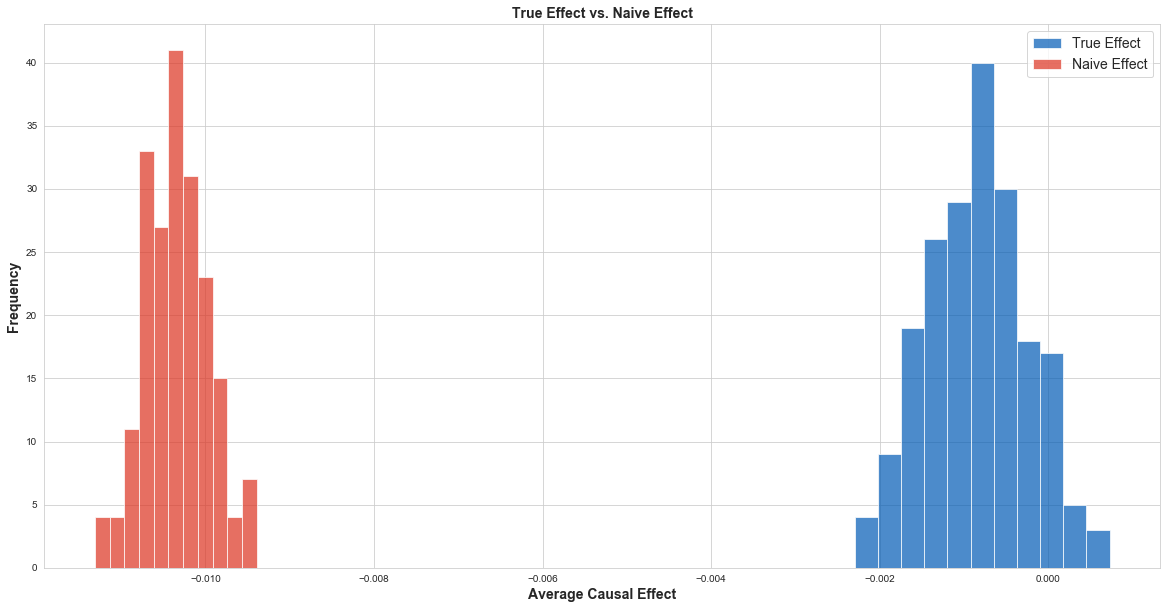

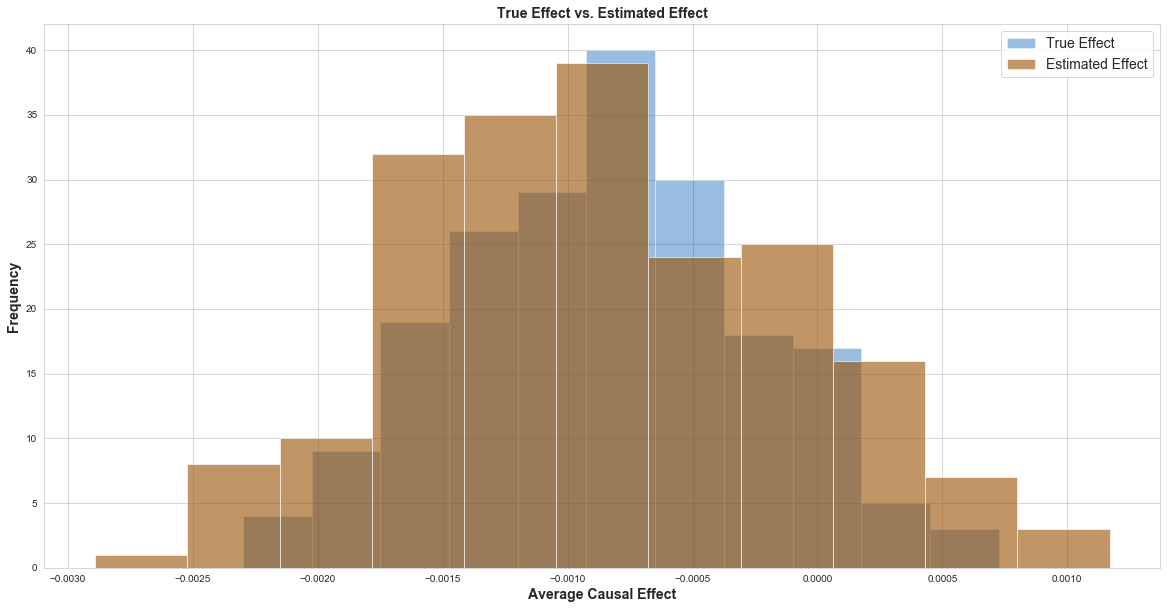

In [44]:
plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")
sns.distplot(
    causal_effects.true_effect,
    label="True Effect",
    kde=False,
    color="#005AB5",
    hist_kws={'alpha':0.7}
)
sns.distplot(
    causal_effects.naive_effect,
    label="Naive Effect",
    kde=False,
    color="#DC3220",
    hist_kws={'alpha':0.7}
)
plt.title(
    "True Effect vs. Naive Effect",
    fontdict={"fontsize": 14, "fontweight": "bold"},
)
plt.ylabel(
    "Frequency",
    rotation=90,
    labelpad=5,
    fontdict={"fontsize": 14, "fontweight": "bold"},
)
plt.xlabel(
    "Average Causal Effect", fontdict={"fontsize": 14, "fontweight": "bold"}
)
plt.legend(prop={"size": 14})

###########################
###########################

plt.figure(figsize=(20, 10))
sns.distplot(
    causal_effects.true_effect, label="True Effect", kde=False, color="#005AB5"
)
sns.distplot(
    causal_effects.estimated_effect,
    label="Estimated Effect",
    kde=False,
    color="#994F00",
    hist_kws={'alpha':0.6}
)
plt.title(
    "True Effect vs. Estimated Effect",
    fontdict={"fontsize": 14, "fontweight": "bold"},
)
plt.ylabel(
    "Frequency",
    rotation=90,
    labelpad=5,
    fontdict={"fontsize": 14, "fontweight": "bold"},
)
plt.xlabel(
    "Average Causal Effect", fontdict={"fontsize": 14, "fontweight": "bold"}
)
plt.legend(prop={"size": 14})

# Conclusion

The main conclusion from this notebook is that assigning causal intepretations to model parameters is only valid if we draw clear assumptions about the data generation process about the question at hand. The data generating process was shown to be important even as the outcome model remained unchanged. Drawing a causal graph (and testing its validity with the data at hand) allows one to clearly state their assumptions about the data generating process and to clearly assign causal interpretations to specific model parameters.